# Amazon SageMaker Notebook for ProcGen Starter Kit with Single Instance

In [ ]:
import os
import json

import sagemaker
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
import boto3

In [ ]:
with open(os.path.join("config", "sagemaker_config.yaml")) as f:
    sagemaker_config = json.load(f)

## Initialize Amazon SageMaker

In [ ]:
sm_session = sagemaker.session.Session()
s3_bucket = sagemaker_config["S3Bucket"]

s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

In [ ]:
job_name_prefix = sagemaker_config["SolutionPrefix"]+'-'

role = sagemaker_config["SageMakerIamRoleArn"]
print(role)

### Configure training instance type and computational resources

By default (`local_mode=False`) launch a separate instance for training and debug using the AWS CloudWatch to monitor the logs for the training instance. 
If you want to train on the same instance as your notebook for quick debugging, then set `local_mode=True`. 

The recommended instances include with cost per hour as of September, 1, 2020 are:
* `ml.c5.4xlarge` $0.952 per hour (16 vCPU)

* `ml.g4dn.4xlarge` $1.686 per hour (1 GPU, 16 vCPU)

* `ml.p3.2xlarge` $4.284 per hour (1 GPU, 8 vCPU)

After you choose your instance type, make sure the edit the resources in [`source\train-sagemaker.py`](./source/train-sagemaker.py). For example, with `ml.p3.2xlarge`, you have 1 GPU and 8 vCPUs. The corresponding resources in [`source\train-sagemaker.py`](./source/train-sagemaker.py) should be set as for `ray` as `

```
    def _get_ray_config(self):
        return {
            "ray_num_cpus": 8, # adjust based on selected instance type
            "ray_num_gpus": 1,
            "eager": False,
             "v": True, # requried for CW to catch the progress
        }
``` 
and for `rrlib` need to use 1 vCPU for driver ("num_workers": 7) and 1 GPU ("num_gpus": 1) for policy training.

In [ ]:
# Change local_mode to True if you want to do local training within this Notebook instance
# Otherwise, we'll spin-up a SageMaker training instance to handle the training

local_mode = False

if local_mode:
    instance_type = 'local'
else:
    instance_type = 'ml.g4dn.4xlarge'
    
# If training locally, do some Docker housekeeping..
if local_mode:
    !/bin/bash source/common/setup.sh

# Configure the framework you want to use

Set `framework` to `"tf"` or `"torch"` for tensorflow or pytorch respectively.

You will also have to edit your entry point i.e., [`train-sagemaker.py`](./source/train-sagemaker.py) with the configuration parameter `"use_pytorch"` to match the framework that you have selected.

In [ ]:
framework = "tf"

# Train your model here

### Edit the training code

The training code is written in the file [`train-project.py`]((./source/train-project.py)) which is uploaded in the /source directory.

#### *Warning: Confirm that the GPU and CPU resources are configured correctly for your instance type as described above.*

In [ ]:
!pygmentize source/train-project.py

### Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. 

When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs.

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code
3. Specify the custom image to be used for the training environment.
4. Define the training parameters such as the instance count, job name, S3 path for output and job name.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

*[Choose](https://github.com/aws/sagemaker-rl-container#rl-images-provided-by-sagemaker) which docker image to use based on the instance type.* 
For this notebook, it has to be a container with Ray 0.8.5 and TensorFlow 2.1.0 to be consistent with the AICrowd ProcGen starter kit. 

If you prefer to use PyTorch, it is recommended to update your notebook kernel to `conda_pytorch_p36`. You would need to substitute for the corresponding container listed on Amazon SageMaker Reinforcement Learning documentation. In addition, you will need to ensure your starter kit is modified to train using PyTorch.

In [ ]:
cpu_or_gpu = 'gpu' if instance_type.startswith(('ml.p', 'ml.g')) else 'cpu'
aws_region = boto3.Session().region_name

# Use Tensorflow 2 by default
custom_image_name = "462105765813.dkr.ecr.{}.amazonaws.com/sagemaker-rl-ray-container:ray-0.8.5-{}-{}-py36".format(aws_region, framework, cpu_or_gpu)
print(custom_image_name)

You need to define metrics to be displayed in the logs. The challenge has requirements on the number of steps and uses mean episode reward to rank various solutions. For details, refer to the AICrowd challange website.

In [ ]:
metric_definitions =  [
    {'Name': 'training_iteration', 'Regex': 'training_iteration: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}, 
    {'Name': 'episodes_total', 'Regex': 'episodes_total: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}, 
    {'Name': 'num_steps_trained', 'Regex': 'num_steps_trained: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}, 
    {'Name': 'timesteps_total', 'Regex': 'timesteps_total: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'},
    {'Name': 'training_iteration', 'Regex': 'training_iteration: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'},

    {'Name': 'episode_reward_max', 'Regex': 'episode_reward_max: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}, 
    {'Name': 'episode_reward_mean', 'Regex': 'episode_reward_mean: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}, 
    {'Name': 'episode_reward_min', 'Regex': 'episode_reward_min: ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'},
] 

### Run the RL estimator

The following are the configurations for all of the experiments conducted in this project. To reproduce some or all of the experiments, simply uncomment the corresponding congirations, and run the next cell containing the RLEstimator code and just wait. Result files will be on your S3 bucket created during the setup for this project on AWS.

In [ ]:
# Experiments config
experiments_to_run = [
#     # No preprocessing, CoinRun, only level 57 (difficulty 2), 100 iterations (2500000 steps)
#     ("NO-CR-57-100", "procgen_env_wrapper", "coinrun", 57, 100),
#     # No preprocessing, CoinRun, only level 164 (difficulty 2), 100 iterations (2500000 steps)
#     ("NO-CR-164-100", "procgen_env_wrapper", "coinrun", 164, 100),
#     # No preprocessing, CaveFlyer, only level 83 (difficulty 2), 100 iterations (2500000 steps)
#     ("NO-CF-83-100", "procgen_env_wrapper", "caveflyer", 83, 100),
#     # No preprocessing, CaveFlyer, only level 145 (difficulty 2), 100 iterations (2500000 steps)
#     ("NO-CF-145-100", "procgen_env_wrapper", "caveflyer", 145, 100),
    
#     # No preprocessing, CoinRun, only level 107 (difficulty 3), 300 iterations (7500000 steps)
#     ("NO-CR-107-300", "procgen_env_wrapper", "coinrun", 107, 300),
#     # No preprocessing, CoinRun, only level 139 (difficulty 3), 300 iterations (7500000 steps)
#     ("NO-CR-139-300", "procgen_env_wrapper", "coinrun", 139, 300),
#     # PG preprocessing, CaveFlyer, only level 1 (difficulty 3), 300 iterations (7500000 steps)
#     ("NO-CF-1-300", "procgen_env_wrapper", "caveflyer", 1, 300),
#     # No preprocessing, CaveFlyer, only level 84 (difficulty 3), 300 iterations (7500000 steps)
#     ("NO-CF-84-300", "procgen_env_wrapper", "caveflyer", 84, 300),

#     # No preprocessing, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("NO-CR-PG-400", "procgen_env_wrapper", "coinrun", -1, 400),
#     # No preprocessing, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("NO-CR-PG-400", "procgen_env_wrapper", "coinrun", -1, 400),
#     # No preprocessing, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("NO-CF-PG-400", "procgen_env_wrapper", "caveflyer", -1, 400),
#     # No preprocessing, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("NO-CF-PG-400", "procgen_env_wrapper", "caveflyer", -1, 400),
    
#     # Cutout, CoinRun, only level 57 (difficulty 2), 100 iterations (2500000 steps)
#     ("CO-CR-57-100", "cutout_env_wrapper", "coinrun", 57, 100),
#     # Cutout, CoinRun, only level 164 (difficulty 2), 100 iterations (2500000 steps)
#     ("CO-CR-164-100", "cutout_env_wrapper", "coinrun", 164, 100),
#     # Cutout, CaveFlyer, only level 83 (difficulty 2), 100 iterations (2500000 steps)
#     ("CO-CF-83-100", "cutout_env_wrapper", "caveflyer", 83, 100),
#     # Cutout, CaveFlyer, only level 145 (difficulty 2), 100 iterations (2500000 steps)
#     ("CO-CF-145-100", "cutout_env_wrapper", "caveflyer", 145, 100),
    
#     # Cutout, CoinRun, only level 107 (difficulty 3), 300 iterations (7500000 steps)
#     ("CO-CR-107-300", "cutout_env_wrapper", "coinrun", 107, 300),
#     # Cutout, CoinRun, only level 139 (difficulty 3), 300 iterations (7500000 steps)
#     ("CO-CR-139-300", "cutout_env_wrapper", "coinrun", 139, 300),
#     # Cutout, CaveFlyer, only level 1 (difficulty 3), 300 iterations (7500000 steps)
#     ("CO-CF-1-300", "cutout_env_wrapper", "caveflyer", 1, 300),
#     # Cutout, CaveFlyer, only level 84 (difficulty 3), 300 iterations (7500000 steps)
#     ("CO-CF-84-300", "cutout_env_wrapper", "caveflyer", 84, 300),
    
#     # Cutout, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("CO-CR-PG-400", "cutout_env_wrapper", "coinrun", -1, 400),
#     # Cutout, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("CO-CR-PG-400", "cutout_env_wrapper", "coinrun", -1, 400),
#     # Cutout, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("CO-CF-PG-400", "cutout_env_wrapper", "caveflyer", -1, 400),
#     # Cutout, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("CO-CF-PG-400", "cutout_env_wrapper", "caveflyer", -1, 400),

#     # Zoom in 1.25x, CoinRun, only level 57 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-57-100", "zoom_in_1.25_env_wrapper", "coinrun", 57, 100),
#     # Zoom in 1.25x, CoinRun, only level 164 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-164-100", "zoom_in_1.25_env_wrapper", "coinrun", 164, 100),
#     # Zoom in 1.25x, CaveFlyer, only level 83 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-83-100", "zoom_in_1.25_env_wrapper", "caveflyer", 83, 100),
#     # Zoom in 1.25x, CaveFlyer, only level 145 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-145-100", "zoom_in_1.25_env_wrapper", "caveflyer", 145, 100),

#     # Zoom in 1.25x, CoinRun, only level 107 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-107-300", "zoom_in_1.25_env_wrapper", "coinrun", 107, 300),
#     # Zoom in 1.25x, CoinRun, only level 139 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-139-300", "zoom_in_1.25_env_wrapper", "coinrun", 139, 300),
#     # Zoom in 1.25x, CaveFlyer, only level 1 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-1-300", "zoom_in_1.25_env_wrapper", "caveflyer", 1, 300),
#     # Zoom in 1.25x, CaveFlyer, only level 84 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-84-300", "zoom_in_1.25_env_wrapper", "caveflyer", 84, 300),

#     # Zoom in 1.25x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CR-PG-400", "zoom_in_1.25_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 1.25x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CR-PG-400", "zoom_in_1.25_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 1.25x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CF-PG-400", "zoom_in_1.25_env_wrapper", "caveflyer", -1, 400),
#     # Zoom in 1.25x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CF-PG-400", "zoom_in_1.25_env_wrapper", "caveflyer", -1, 400),

#     # Zoom in 1.5x, CoinRun, only level 57 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-57-100", "zoom_in_1.5_env_wrapper", "coinrun", 57, 100),
#     # Zoom in 1.5x, CoinRun, only level 164 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-164-100", "zoom_in_1.5_env_wrapper", "coinrun", 164, 100),
#     # Zoom in 1.5x, CaveFlyer, only level 83 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-83-100", "zoom_in_1.5_env_wrapper", "caveflyer", 83, 100),
#     # Zoom in 1.5x, CaveFlyer, only level 145 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-145-100", "zoom_in_1.5_env_wrapper", "caveflyer", 145, 100),

#     # Zoom in 1.5x, CoinRun, only level 107 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-107-300", "zoom_in_1.5_env_wrapper", "coinrun", 107, 300),
#     # Zoom in 1.5x, CoinRun, only level 139 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-139-300", "zoom_in_1.5_env_wrapper", "coinrun", 139, 300),
#     # Zoom in 1.5x, CaveFlyer, only level 1 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-1-300", "zoom_in_1.5_env_wrapper", "caveflyer", 1, 300),
#     # Zoom in 1.5x, CaveFlyer, only level 84 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-84-300", "zoom_in_1.5_env_wrapper", "caveflyer", 84, 300),

#     # Zoom in 1.5x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CR-PG-400", "zoom_in_1.5_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 1.5x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CR-PG-400", "zoom_in_1.5_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 1.5x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CF-PG-400", "zoom_in_1.5_env_wrapper", "caveflyer", -1, 400),
#     # Zoom in 1.5x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CF-PG-400", "zoom_in_1.5_env_wrapper", "caveflyer", -1, 400),

#     # Zoom in 2.0x, CoinRun, only level 57 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-57-100", "zoom_in_2.0_env_wrapper", "coinrun", 57, 100),
#     # Zoom in 2.0x, CoinRun, only level 164 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-164-100", "zoom_in_2.0_env_wrapper", "coinrun", 164, 100),
#     # Zoom in 2.0x, CaveFlyer, only level 83 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-83-100", "zoom_in_2.0_env_wrapper", "caveflyer", 83, 100),
#     # Zoom in 2.0x, CaveFlyer, only level 145 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-145-100", "zoom_in_2.0_env_wrapper", "caveflyer", 145, 100),

#     # Zoom in 2.0x, CoinRun, only level 107 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-107-300", "zoom_in_2.0_env_wrapper", "coinrun", 107, 300),
#     # Zoom in 2.0x, CoinRun, only level 139 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-139-300", "zoom_in_2.0_env_wrapper", "coinrun", 139, 300),
#     # Zoom in 2.0x, CaveFlyer, only level 1 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-1-300", "zoom_in_2.0_env_wrapper", "caveflyer", 1, 300),
#     # Zoom in 2.0x, CaveFlyer, only level 84 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-84-300", "zoom_in_2.0_env_wrapper", "caveflyer", 84, 300),

#     # Zoom in 2.0x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CR-PG-400", "zoom_in_2.0_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 2.0x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CR-PG-400", "zoom_in_2.0_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 2.0x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CF-PG-400", "zoom_in_2.0_env_wrapper", "caveflyer", -1, 400),
#     # Zoom in 2.0x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CF-PG-400", "zoom_in_2.0_env_wrapper", "caveflyer", -1, 400),

#     # Zoom in 3.0x, CoinRun, only level 57 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-57-100", "zoom_in_3.0_env_wrapper", "coinrun", 57, 100),
#     # Zoom in 3.0x, CoinRun, only level 164 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CR-164-100", "zoom_in_3.0_env_wrapper", "coinrun", 164, 100),
#     # Zoom in 3.0x, CaveFlyer, only level 83 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-83-100", "zoom_in_3.0_env_wrapper", "caveflyer", 83, 100),
#     # Zoom in 3.0x, CaveFlyer, only level 145 (difficulty 2), 100 iterations (2500000 steps)
#     ("ZI-CF-145-100", "zoom_in_3.0_env_wrapper", "caveflyer", 145, 100),

#     # Zoom in 3.0x, CoinRun, only level 107 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-107-300", "zoom_in_3.0_env_wrapper", "coinrun", 107, 300),
#     # Zoom in 3.0x, CoinRun, only level 139 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CR-139-300", "zoom_in_3.0_env_wrapper", "coinrun", 139, 300),
#     # Zoom in 3.0x, CaveFlyer, only level 1 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-1-300", "zoom_in_3.0_env_wrapper", "caveflyer", 1, 300),
#     # Zoom in 3.0x, CaveFlyer, only level 84 (difficulty 3), 300 iterations (7500000 steps)
#     ("ZI-CF-84-300", "zoom_in_3.0_env_wrapper", "caveflyer", 84, 300),

#     # Zoom in 3.0x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CR-PG-400", "zoom_in_3.0_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 3.0x, CoinRun, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CR-PG-400", "zoom_in_3.0_env_wrapper", "coinrun", -1, 400),
#     # Zoom in 3.0x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 1
#     ("ZI-CF-PG-400", "zoom_in_3.0_env_wrapper", "caveflyer", -1, 400),
#     # Zoom in 3.0x, CaveFlyer, first 200 levels, 400 iterations (10000000 steps), run 2
#     ("ZI-CF-PG-400", "zoom_in_3.0_env_wrapper", "caveflyer", -1, 400),
]

In [ ]:
training_jobs_names = []
for name, env_wrapper, env, level, iters in experiments_to_run:
    args = {
        "rl.training.env": env_wrapper,
        "rl.training.stop.training_iteration": iters,
        "rl.training.config.env_config.env_name": env,
    }
    if level < 0:
        args["rl.training.config.evaluation_interval"] = 10
        args["rl.training.config.evaluation_config.env_config.env_name"] = env
    else:
        args["rl.training.config.env_config.num_levels"] = 1
        args["rl.training.config.env_config.start_level"] = level

    estimator = RLEstimator(entry_point="train-project.py",
                            source_dir="source",
                            dependencies=["source/utils", "source/common/", "neurips2020-procgen-starter-kit/"],
                            image_uri=custom_image_name,
                            role=role,
                            instance_type=instance_type,
                            instance_count=1,
                            output_path=s3_output_path,
                            base_job_name=name,
                            metric_definitions=metric_definitions,
                            debugger_hook_config=False,
                            hyperparameters=args
                        )
    estimator.fit(logs="None")

    training_jobs_names.append(estimator.latest_training_job.name)

## Evaluate the model
The following are exactly the code used to generate the figures from the result files.

In [61]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
NO_CR_57_100 = pd.read_csv("results/100/NO-CR-57-100/progress.csv")
CO_CR_57_100 = pd.read_csv("results/100/CO-CR-57-100/progress.csv")
ZI_1_25_CR_57_100 = pd.read_csv("results/100/ZI-1-25-CR-57-100/progress.csv")
ZI_1_50_CR_57_100 = pd.read_csv("results/100/ZI-1-50-CR-57-100/progress.csv")
ZI_2_00_CR_57_100 = pd.read_csv("results/100/ZI-2-00-CR-57-100/progress.csv")
ZI_3_00_CR_57_100 = pd.read_csv("results/100/ZI-3-00-CR-57-100/progress.csv")

NO_CR_164_100 = pd.read_csv("results/100/NO-CR-164-100/progress.csv")
CO_CR_164_100 = pd.read_csv("results/100/CO-CR-164-100/progress.csv")
ZI_1_25_CR_164_100 = pd.read_csv("results/100/ZI-1-25-CR-164-100/progress.csv")
ZI_1_50_CR_164_100 = pd.read_csv("results/100/ZI-1-50-CR-164-100/progress.csv")
ZI_2_00_CR_164_100 = pd.read_csv("results/100/ZI-2-00-CR-164-100/progress.csv")
ZI_3_00_CR_164_100 = pd.read_csv("results/100/ZI-3-00-CR-164-100/progress.csv")

NO_CF_83_100 = pd.read_csv("results/100/NO-CF-83-100/progress.csv")
CO_CF_83_100 = pd.read_csv("results/100/CO-CF-83-100/progress.csv")
ZI_1_25_CF_83_100 = pd.read_csv("results/100/ZI-1-25-CF-83-100/progress.csv")
ZI_1_50_CF_83_100 = pd.read_csv("results/100/ZI-1-50-CF-83-100/progress.csv")
ZI_2_00_CF_83_100 = pd.read_csv("results/100/ZI-2-00-CF-83-100/progress.csv")
ZI_3_00_CF_83_100 = pd.read_csv("results/100/ZI-3-00-CF-83-100/progress.csv")

NO_CF_145_100 = pd.read_csv("results/100/NO-CF-145-100/progress.csv")
CO_CF_145_100 = pd.read_csv("results/100/CO-CF-145-100/progress.csv")
ZI_1_25_CF_145_100 = pd.read_csv("results/100/ZI-1-25-CF-145-100/progress.csv")
ZI_1_50_CF_145_100 = pd.read_csv("results/100/ZI-1-50-CF-145-100/progress.csv")
ZI_2_00_CF_145_100 = pd.read_csv("results/100/ZI-2-00-CF-145-100/progress.csv")
ZI_3_00_CF_145_100 = pd.read_csv("results/100/ZI-3-00-CF-145-100/progress.csv")

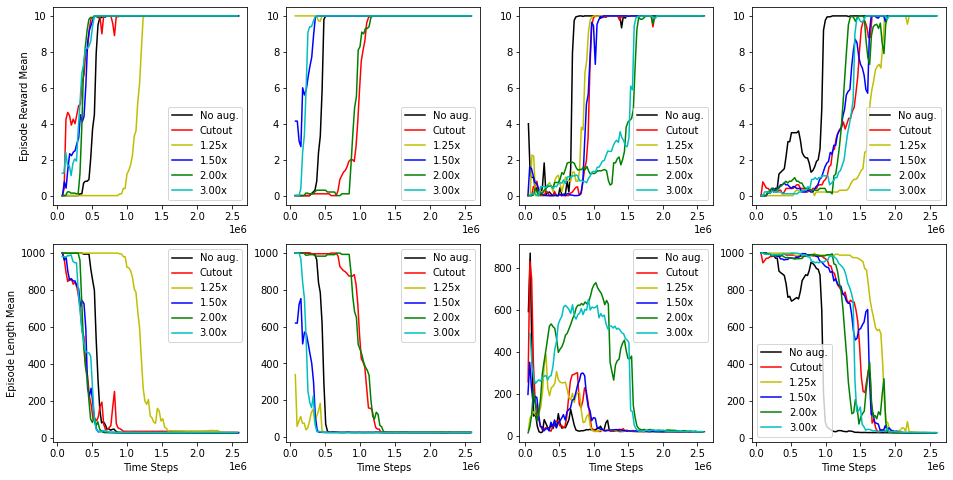

In [5]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CR_57_100, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CR_57_100, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CR_57_100, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CR_57_100, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CR_57_100, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CR_57_100, label='3.00x')
plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(245)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CR_57_100, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CR_57_100, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CR_57_100, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CR_57_100, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CR_57_100, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CR_57_100, label='3.00x')
plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(242)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CR_164_100, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CR_164_100, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CR_164_100, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CR_164_100, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CR_164_100, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CR_164_100, label='3.00x')
# plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(246)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CR_164_100, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CR_164_100, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CR_164_100, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CR_164_100, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CR_164_100, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CR_164_100, label='3.00x')
# plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(243)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CF_83_100, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CF_83_100, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CF_83_100, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CF_83_100, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CF_83_100, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CF_83_100, label='3.00x')
# plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(247)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CF_83_100, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CF_83_100, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CF_83_100, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CF_83_100, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CF_83_100, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CF_83_100, label='3.00x')
# plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(244)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CF_145_100, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CF_145_100, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CF_145_100, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CF_145_100, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CF_145_100, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CF_145_100, label='3.00x')
# plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(248)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CF_145_100, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CF_145_100, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CF_145_100, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CF_145_100, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CF_145_100, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CF_145_100, label='3.00x')
# plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.savefig('results/100.pdf', transparent=False, bbox_inches="tight")

In [57]:
NO_CF_1_300_N = pd.read_csv("results/300/NO-CF-1-300/progress.csv")[::3]
NO_CF_1_300_O = pd.read_csv("results/300/NO-CF-1-300/progress original.csv")[::3]
CO_CF_1_300 = pd.read_csv("results/300/CO-CF-1-300/progress.csv")[::3]
ZI_1_25_CF_1_300 = pd.read_csv("results/300/ZI-1-25-CF-1-300/progress.csv")[::3]
ZI_1_50_CF_1_300 = pd.read_csv("results/300/ZI-1-50-CF-1-300/progress.csv")[::3]
ZI_2_00_CF_1_300 = pd.read_csv("results/300/ZI-2-00-CF-1-300/progress.csv")[::3]
ZI_3_00_CF_1_300 = pd.read_csv("results/300/ZI-3-00-CF-1-300/progress.csv")[::3]

NO_CF_84_300_N = pd.read_csv("results/300/NO-CF-84-300/progress.csv")[::3]
NO_CF_84_300_O = pd.read_csv("results/300/NO-CF-84-300/progress original.csv")[::3]
CO_CF_84_300 = pd.read_csv("results/300/CO-CF-84-300/progress.csv")[::3]
ZI_1_25_CF_84_300 = pd.read_csv("results/300/ZI-1-25-CF-84-300/progress.csv")[::3]
ZI_1_50_CF_84_300 = pd.read_csv("results/300/ZI-1-50-CF-84-300/progress.csv")[::3]
ZI_2_00_CF_84_300 = pd.read_csv("results/300/ZI-2-00-CF-84-300/progress.csv")[::3]
ZI_3_00_CF_84_300 = pd.read_csv("results/300/ZI-3-00-CF-84-300/progress.csv")[::3]

NO_CR_107_300_N = pd.read_csv("results/300/NO-CR-107-300/progress.csv")[::3]
NO_CR_107_300_O = pd.read_csv("results/300/NO-CR-107-300/progress original.csv")[::3]
CO_CR_107_300 = pd.read_csv("results/300/CO-CR-107-300/progress.csv")[::3]
ZI_1_25_CR_107_300 = pd.read_csv("results/300/ZI-1-25-CR-107-300/progress.csv")[::3]
ZI_1_50_CR_107_300 = pd.read_csv("results/300/ZI-1-50-CR-107-300/progress.csv")[::3]
ZI_2_00_CR_107_300 = pd.read_csv("results/300/ZI-2-00-CR-107-300/progress.csv")[::3]
ZI_3_00_CR_107_300 = pd.read_csv("results/300/ZI-3-00-CR-107-300/progress.csv")[::3]

NO_CR_139_300_N = pd.read_csv("results/300/NO-CR-139-300/progress.csv")[::3]
NO_CR_139_300_O = pd.read_csv("results/300/NO-CR-139-300/progress original.csv")[::3]
CO_CR_139_300 = pd.read_csv("results/300/CO-CR-139-300/progress.csv")[::3]
ZI_1_25_CR_139_300 = pd.read_csv("results/300/ZI-1-25-CR-139-300/progress.csv")[::3]
ZI_1_50_CR_139_300 = pd.read_csv("results/300/ZI-1-50-CR-139-300/progress.csv")[::3]
ZI_2_00_CR_139_300 = pd.read_csv("results/300/ZI-2-00-CR-139-300/progress.csv")[::3]
ZI_3_00_CR_139_300 = pd.read_csv("results/300/ZI-3-00-CR-139-300/progress.csv")[::3]

In [58]:
NO_CF_1_300 = pd.concat([NO_CF_1_300_N, NO_CF_1_300_O])
NO_CF_84_300 = pd.concat([NO_CF_84_300_N, NO_CF_84_300_O])
NO_CR_107_300 = pd.concat([NO_CR_107_300_N, NO_CR_107_300_O])
NO_CR_139_300 = pd.concat([NO_CR_139_300_N, NO_CR_139_300_O])

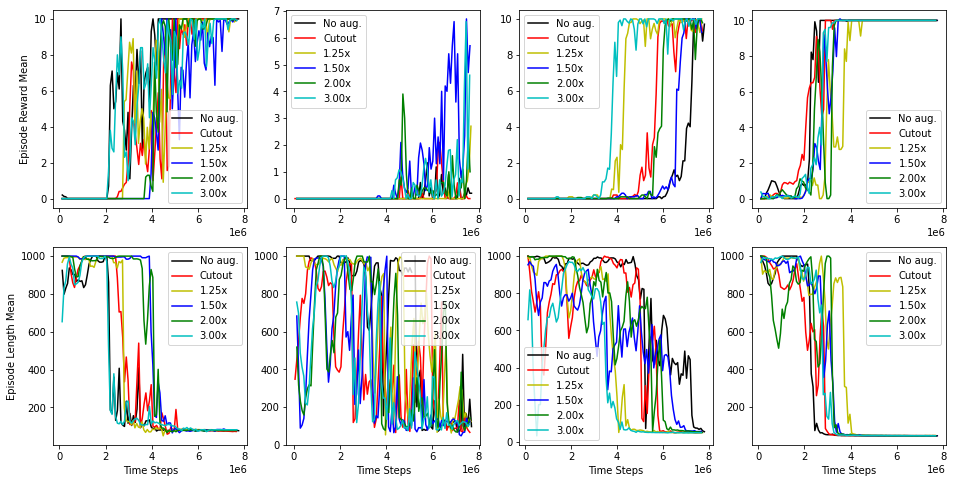

In [59]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CR_107_300, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CR_107_300, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CR_107_300, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CR_107_300, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CR_107_300, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CR_107_300, label='3.00x')
plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(245)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CR_107_300, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CR_107_300, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CR_107_300, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CR_107_300, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CR_107_300, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CR_107_300, label='3.00x')
plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(242)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CR_139_300, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CR_139_300, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CR_139_300, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CR_139_300, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CR_139_300, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CR_139_300, label='3.00x')
# plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(246)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CR_139_300, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CR_139_300, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CR_139_300, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CR_139_300, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CR_139_300, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CR_139_300, label='3.00x')
# plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(243)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CF_1_300, markevery=10, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CF_1_300, markevery=10, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CF_1_300, markevery=10, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CF_1_300, markevery=10, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CF_1_300, markevery=10, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CF_1_300, markevery=10, label='3.00x')
# plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(247)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CF_1_300, markevery=10, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CF_1_300, markevery=10, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CF_1_300, markevery=10, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CF_1_300, markevery=10, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CF_1_300, markevery=10, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CF_1_300, markevery=10, label='3.00x')
# plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(244)
plt.plot('timesteps_total', 'episode_reward_mean', 'k', data=NO_CF_84_300, label='No aug.')
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CF_84_300, label='Cutout')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CF_84_300, label='1.25x')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CF_84_300, label='1.50x')
plt.plot('timesteps_total', 'episode_reward_mean', 'g', data=ZI_2_00_CF_84_300, label='2.00x')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CF_84_300, label='3.00x')
# plt.ylabel("Episode Reward Mean")
# plt.xlabel("Time Steps")
plt.legend()
plt.subplot(248)
plt.plot('timesteps_total', 'episode_len_mean', 'k', data=NO_CF_84_300, label='No aug.')
plt.plot('timesteps_total', 'episode_len_mean', 'r', data=CO_CF_84_300, label='Cutout')
plt.plot('timesteps_total', 'episode_len_mean', 'y', data=ZI_1_25_CF_84_300, label='1.25x')
plt.plot('timesteps_total', 'episode_len_mean', 'b', data=ZI_1_50_CF_84_300, label='1.50x')
plt.plot('timesteps_total', 'episode_len_mean', 'g', data=ZI_2_00_CF_84_300, label='2.00x')
plt.plot('timesteps_total', 'episode_len_mean', 'c', data=ZI_3_00_CF_84_300, label='3.00x')
# plt.ylabel("Episode Length Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.savefig('results/300.pdf', transparent=False, bbox_inches="tight")

In [24]:
import json

In [50]:
NO_CR_PG_400_1_J = json.load(open("results/400/NO-CR-PG-400/1/result.json"))
NO_CR_PG_400_2_J = json.load(open("results/400/NO-CR-PG-400/2/result.json"))
CO_CR_PG_400_1_J = json.load(open("results/400/CO-CR-PG-400/1/result.json"))
CO_CR_PG_400_2_J = json.load(open("results/400/CO-CR-PG-400/2/result.json"))
ZI_1_25_CR_PG_400_1_J = json.load(open("results/400/ZI-1-25-CR-PG-400/1/result.json"))
ZI_1_25_CR_PG_400_2_J = json.load(open("results/400/ZI-1-25-CR-PG-400/2/result.json"))
ZI_1_50_CR_PG_400_1_J = json.load(open("results/400/ZI-1-50-CR-PG-400/1/result.json"))
ZI_1_50_CR_PG_400_2_J = json.load(open("results/400/ZI-1-50-CR-PG-400/2/result.json"))
ZI_2_00_CR_PG_400_1_J = json.load(open("results/400/ZI-2-00-CR-PG-400/1/result.json"))
ZI_2_00_CR_PG_400_2_J = json.load(open("results/400/ZI-2-00-CR-PG-400/2/result.json"))
ZI_3_00_CR_PG_400_1_J = json.load(open("results/400/ZI-3-00-CR-PG-400/1/result.json"))
ZI_3_00_CR_PG_400_2_J = json.load(open("results/400/ZI-3-00-CR-PG-400/2/result.json"))

NO_CF_PG_400_1_J = json.load(open("results/400/NO-CF-PG-400/1/result.json"))
NO_CF_PG_400_2_J = json.load(open("results/400/NO-CF-PG-400/2/result.json"))
CO_CF_PG_400_1_J = json.load(open("results/400/CO-CF-PG-400/1/result.json"))
CO_CF_PG_400_2_J = json.load(open("results/400/CO-CF-PG-400/2/result.json"))
ZI_1_25_CF_PG_400_1_J = json.load(open("results/400/ZI-1-25-CF-PG-400/1/result.json"))
ZI_1_25_CF_PG_400_2_J = json.load(open("results/400/ZI-1-25-CF-PG-400/2/result.json"))
ZI_1_50_CF_PG_400_1_J = json.load(open("results/400/ZI-1-50-CF-PG-400/1/result.json"))
ZI_1_50_CF_PG_400_2_J = json.load(open("results/400/ZI-1-50-CF-PG-400/2/result.json"))
ZI_2_00_CF_PG_400_1_J = json.load(open("results/400/ZI-2-00-CF-PG-400/1/result.json"))
ZI_2_00_CF_PG_400_2_J = json.load(open("results/400/ZI-2-00-CF-PG-400/2/result.json"))
ZI_3_00_CF_PG_400_1_J = json.load(open("results/400/ZI-3-00-CF-PG-400/1/result.json"))
ZI_3_00_CF_PG_400_2_J = json.load(open("results/400/ZI-3-00-CF-PG-400/2/result.json"))


In [29]:
def get_test_data(j):
    return pd.DataFrame({
        'timesteps_total' : pd.Series([t['timesteps_total'] for t in j if 'evaluation' in t]), 
        'episode_reward_mean' : pd.Series([t['evaluation']['episode_reward_mean'] for t in j if 'evaluation' in t])
    })

In [51]:
NO_CR_PG_400_1_T = get_test_data(NO_CR_PG_400_1_J)
NO_CR_PG_400_2_T = get_test_data(NO_CR_PG_400_2_J)
CO_CR_PG_400_1_T = get_test_data(CO_CR_PG_400_1_J)
CO_CR_PG_400_2_T = get_test_data(CO_CR_PG_400_2_J)
ZI_1_25_CR_PG_400_1_T = get_test_data(ZI_1_25_CR_PG_400_1_J)
ZI_1_25_CR_PG_400_2_T = get_test_data(ZI_1_25_CR_PG_400_2_J)
ZI_1_50_CR_PG_400_1_T = get_test_data(ZI_1_50_CR_PG_400_1_J)
ZI_1_50_CR_PG_400_2_T = get_test_data(ZI_1_50_CR_PG_400_2_J)
ZI_2_00_CR_PG_400_1_T = get_test_data(ZI_2_00_CR_PG_400_1_J)
ZI_2_00_CR_PG_400_2_T = get_test_data(ZI_2_00_CR_PG_400_2_J)
ZI_3_00_CR_PG_400_1_T = get_test_data(ZI_3_00_CR_PG_400_1_J)
ZI_3_00_CR_PG_400_2_T = get_test_data(ZI_3_00_CR_PG_400_2_J)

NO_CF_PG_400_1_T = get_test_data(NO_CF_PG_400_1_J)
NO_CF_PG_400_2_T = get_test_data(NO_CF_PG_400_2_J)
CO_CF_PG_400_1_T = get_test_data(CO_CF_PG_400_1_J)
CO_CF_PG_400_2_T = get_test_data(CO_CF_PG_400_2_J)
ZI_1_25_CF_PG_400_1_T = get_test_data(ZI_1_25_CF_PG_400_1_J)
ZI_1_25_CF_PG_400_2_T = get_test_data(ZI_1_25_CF_PG_400_2_J)
ZI_1_50_CF_PG_400_1_T = get_test_data(ZI_1_50_CF_PG_400_1_J)
ZI_1_50_CF_PG_400_2_T = get_test_data(ZI_1_50_CF_PG_400_2_J)
ZI_2_00_CF_PG_400_1_T = get_test_data(ZI_2_00_CF_PG_400_1_J)
ZI_2_00_CF_PG_400_2_T = get_test_data(ZI_2_00_CF_PG_400_2_J)
ZI_3_00_CF_PG_400_1_T = get_test_data(ZI_3_00_CF_PG_400_1_J)
ZI_3_00_CF_PG_400_2_T = get_test_data(ZI_3_00_CF_PG_400_2_J)


In [14]:
NO_CR_PG_400_1 = pd.read_csv("results/400/NO-CR-PG-400/1/progress.csv")[::4]
NO_CR_PG_400_2 = pd.read_csv("results/400/NO-CR-PG-400/2/progress.csv")[::4]
CO_CR_PG_400_1 = pd.read_csv("results/400/CO-CR-PG-400/1/progress.csv")[::4]
CO_CR_PG_400_2 = pd.read_csv("results/400/CO-CR-PG-400/2/progress.csv")[::4]
ZI_1_25_CR_PG_400_1 = pd.read_csv("results/400/ZI-1-25-CR-PG-400/1/progress.csv")[::4]
ZI_1_25_CR_PG_400_2 = pd.read_csv("results/400/ZI-1-25-CR-PG-400/2/progress.csv")[::4]
ZI_1_50_CR_PG_400_1 = pd.read_csv("results/400/ZI-1-50-CR-PG-400/1/progress.csv")[::4]
ZI_1_50_CR_PG_400_2 = pd.read_csv("results/400/ZI-1-50-CR-PG-400/2/progress.csv")[::4]
ZI_2_00_CR_PG_400_1 = pd.read_csv("results/400/ZI-2-00-CR-PG-400/1/progress.csv")[::4]
ZI_2_00_CR_PG_400_2 = pd.read_csv("results/400/ZI-2-00-CR-PG-400/2/progress.csv")[::4]
ZI_3_00_CR_PG_400_1 = pd.read_csv("results/400/ZI-3-00-CR-PG-400/1/progress.csv")[::4]
ZI_3_00_CR_PG_400_2 = pd.read_csv("results/400/ZI-3-00-CR-PG-400/2/progress.csv")[::4]

NO_CF_PG_400_1 = pd.read_csv("results/400/NO-CF-PG-400/1/progress.csv")[::4]
NO_CF_PG_400_2 = pd.read_csv("results/400/NO-CF-PG-400/2/progress.csv")[::4]
CO_CF_PG_400_1 = pd.read_csv("results/400/CO-CF-PG-400/1/progress.csv")[::4]
CO_CF_PG_400_2 = pd.read_csv("results/400/CO-CF-PG-400/2/progress.csv")[::4]
ZI_1_25_CF_PG_400_1 = pd.read_csv("results/400/ZI-1-25-CF-PG-400/1/progress.csv")[::4]
ZI_1_25_CF_PG_400_2 = pd.read_csv("results/400/ZI-1-25-CF-PG-400/2/progress.csv")[::4]
ZI_1_50_CF_PG_400_1 = pd.read_csv("results/400/ZI-1-50-CF-PG-400/1/progress.csv")[::4]
ZI_1_50_CF_PG_400_2 = pd.read_csv("results/400/ZI-1-50-CF-PG-400/2/progress.csv")[::4]
ZI_2_00_CF_PG_400_1 = pd.read_csv("results/400/ZI-2-00-CF-PG-400/1/progress.csv")[::4]
ZI_2_00_CF_PG_400_2 = pd.read_csv("results/400/ZI-2-00-CF-PG-400/2/progress.csv")[::4]
ZI_3_00_CF_PG_400_1 = pd.read_csv("results/400/ZI-3-00-CF-PG-400/1/progress.csv")[::4]
ZI_3_00_CF_PG_400_2 = pd.read_csv("results/400/ZI-3-00-CF-PG-400/2/progress.csv")[::4]

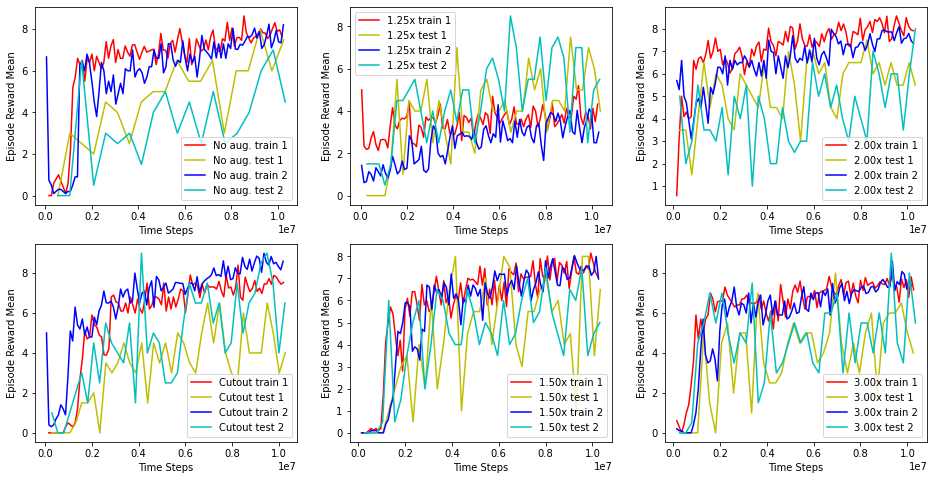

In [46]:
plt.figure(figsize=(16, 8))

plt.subplot(231)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=NO_CR_PG_400_1, label='No aug. train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=NO_CR_PG_400_1_T, label='No aug. test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=NO_CR_PG_400_2, label='No aug. train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=NO_CR_PG_400_2_T, label='No aug. test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(234)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CR_PG_400_1, label='Cutout train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=CO_CR_PG_400_1_T, label='Cutout test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=CO_CR_PG_400_2, label='Cutout train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=CO_CR_PG_400_2_T, label='Cutout test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(232)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_1_25_CR_PG_400_1, label='1.25x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CR_PG_400_1_T, label='1.25x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_25_CR_PG_400_2, label='1.25x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_1_25_CR_PG_400_2_T, label='1.25x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(235)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_1_50_CR_PG_400_1, label='1.50x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_50_CR_PG_400_1_T, label='1.50x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CR_PG_400_2, label='1.50x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_1_50_CR_PG_400_2_T, label='1.50x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(233)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_2_00_CR_PG_400_1, label='2.00x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_2_00_CR_PG_400_1_T, label='2.00x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_2_00_CR_PG_400_2, label='2.00x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_2_00_CR_PG_400_2_T, label='2.00x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(236)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_3_00_CR_PG_400_1, label='3.00x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_3_00_CR_PG_400_1_T, label='3.00x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_3_00_CR_PG_400_2, label='3.00x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CR_PG_400_2_T, label='3.00x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.savefig('results/PGCR.pdf', transparent=False, bbox_inches="tight")

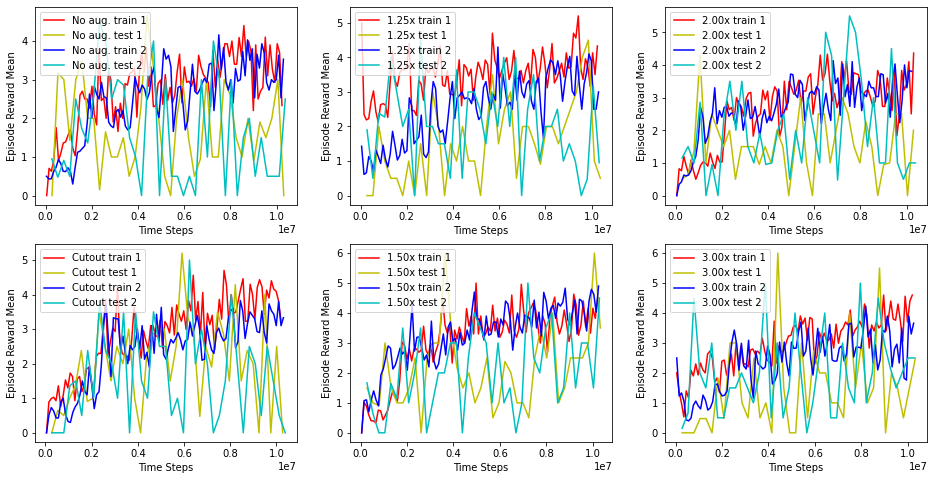

In [52]:
plt.figure(figsize=(16, 8))

plt.subplot(231)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=NO_CF_PG_400_1, label='No aug. train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=NO_CF_PG_400_1_T, label='No aug. test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=NO_CF_PG_400_2, label='No aug. train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=NO_CF_PG_400_2_T, label='No aug. test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(234)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=CO_CF_PG_400_1, label='Cutout train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=CO_CF_PG_400_1_T, label='Cutout test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=CO_CF_PG_400_2, label='Cutout train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=CO_CF_PG_400_2_T, label='Cutout test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(232)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_1_25_CF_PG_400_1, label='1.25x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_25_CF_PG_400_1_T, label='1.25x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_25_CF_PG_400_2, label='1.25x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_1_25_CF_PG_400_2_T, label='1.25x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(235)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_1_50_CF_PG_400_1, label='1.50x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_1_50_CF_PG_400_1_T, label='1.50x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_1_50_CF_PG_400_2, label='1.50x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_1_50_CF_PG_400_2_T, label='1.50x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(233)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_2_00_CF_PG_400_1, label='2.00x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_2_00_CF_PG_400_1_T, label='2.00x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_2_00_CF_PG_400_2, label='2.00x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_2_00_CF_PG_400_2_T, label='2.00x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.subplot(236)
plt.plot('timesteps_total', 'episode_reward_mean', 'r', data=ZI_3_00_CF_PG_400_1, label='3.00x train 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'y', data=ZI_3_00_CF_PG_400_1_T, label='3.00x test 1')
plt.plot('timesteps_total', 'episode_reward_mean', 'b', data=ZI_3_00_CF_PG_400_2, label='3.00x train 2')
plt.plot('timesteps_total', 'episode_reward_mean', 'c', data=ZI_3_00_CF_PG_400_2_T, label='3.00x test 2')
plt.ylabel("Episode Reward Mean")
plt.xlabel("Time Steps")
plt.legend()

plt.savefig('results/PGCF.pdf', transparent=False, bbox_inches="tight")

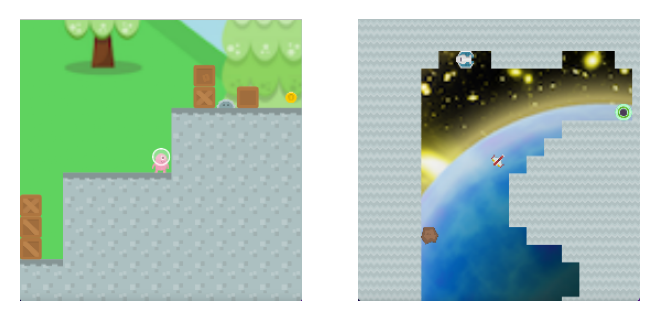

In [70]:
plt.figure(figsize=(4, 8), dpi=200)
plt.subplot(121)
coinrun = mpimg.imread("results/obs/coinrun.png")
plt.imshow(coinrun)
plt.axis('off')
plt.subplot(122)
caveflyer = mpimg.imread("results/obs/caveflyer.png")
plt.imshow(caveflyer)
plt.axis('off')
plt.savefig('results/original.pdf', transparent=False, bbox_inches="tight")

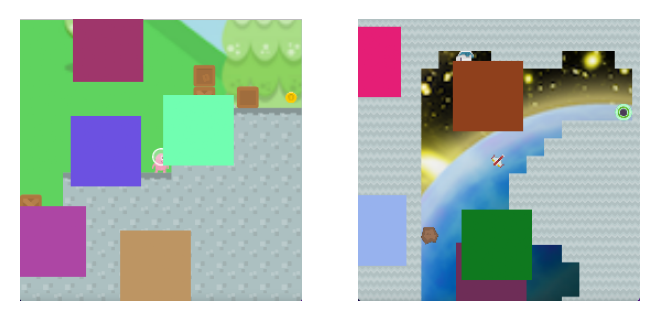

In [71]:
plt.figure(figsize=(4, 8), dpi=200)
plt.subplot(121)
coinrun = mpimg.imread("results/obs/coinrun cutout.png")
plt.imshow(coinrun)
plt.axis('off')
plt.subplot(122)
caveflyer = mpimg.imread("results/obs/caveflyer cutout.png")
plt.imshow(caveflyer)
plt.axis('off')
plt.savefig('results/cutout.pdf', transparent=False, bbox_inches="tight")

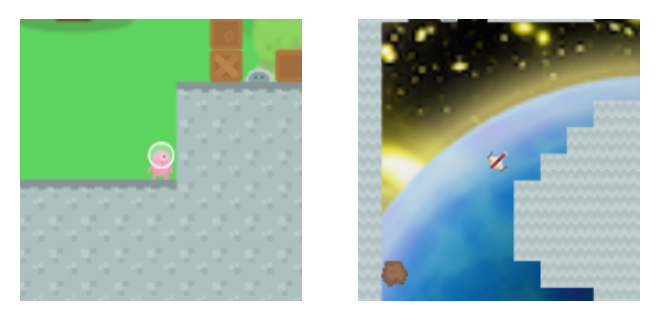

In [72]:
plt.figure(figsize=(4, 8), dpi=200)
plt.subplot(121)
coinrun = mpimg.imread("results/obs/coinrun zoom_in.png")
plt.imshow(coinrun)
plt.axis('off')
plt.subplot(122)
caveflyer = mpimg.imread("results/obs/caveflyer zoom_in.png")
plt.imshow(caveflyer)
plt.axis('off')
plt.savefig('results/zoom_in.pdf', transparent=False, bbox_inches="tight")